Ex 3: operations with PyTorch


In [ ]:
import torch

x = torch.rand(2, 2)
y = torch.rand(2, 2)
z = torch.rand(2, 2)
print(f"x: {x}\n y: {y}")
# move them to the GPU
x = x.cuda()
torch.cuda.is_available()
y = y.cuda()
x.device, y.device

x: tensor([[0.4833, 0.8455],
        [0.4475, 0.4506]])
 y: tensor([[0.4855, 0.2700],
        [0.5875, 0.7836]])


RuntimeError: ignored

In [ ]:
torch.add(x, y)  # adds term to term (element a_ij of each tensor)

# torch.sum can be used to sum along multiple dimensions of the same tensor
torch.sum(x, dim=0)
torch.sum(x, dim=1)

# multiplication
print(f"x*y: {x * y}")  # multiplies each a_ij element by the corresponding one on the other tensor
print(f"x @ y: {x @ y}")  # matrix multiplication
print(f"torch.mul: {torch.mul(x, y)}")  # same as *
print(f"torch.matmul: {torch.matmul(x, y)}")  # same as @ 


# concatenate two tensors along different axis
torch.cat((x, y), dim=-1)

Ex 4: CIFAR10

In [1]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets, utils
import numpy as np
import matplotlib.pyplot as plt

In [13]:
def unpickle(file):
  import pickle
  with open(file, 'rb') as fo:
    dict = pickle.load(fo, encoding='latin1')
  return dict

In [14]:
import os
import numpy as np

In [15]:
from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !tar -xvzf /content/drive/MyDrive/Colab/MLDL/LAB1/cifar-10-python.tar.gz

In [16]:
import tarfile

with tarfile.open("/content/drive/MyDrive/Colab/MLDL/LAB1/cifar-10-python.tar.gz", "r") as tf:
    print("Opened tarfile")
    tf.extractall(path="/content/drive/MyDrive/Colab/MLDL/LAB1")
    print("All files extracted")

Opened tarfile
All files extracted


In [18]:
# path = '/content/drive/MyDrive/Colab/MLDL/LAB1/cifar-10-batches-py/'
# os.listdir(path)
# file1 = path + f'/data_batch_1'
# meta_file  = path + f'/batches.meta'
file1 = '/content/drive/MyDrive/Colab/MLDL/LAB1/cifar-10-batches-py/data_batch_1'
data_1 = unpickle(file1)

meta_file = '/content/drive/MyDrive/Colab/MLDL/LAB1/cifar-10-batches-py/batches.meta'
meta = unpickle(meta_file)

In [19]:
meta['label_names']

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Class: frog


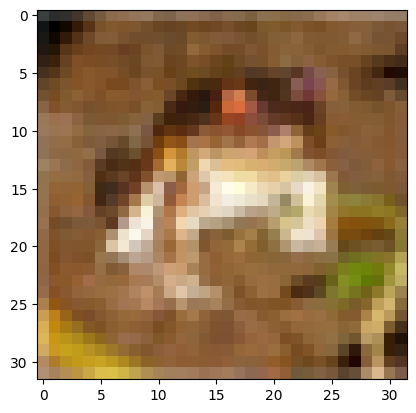

In [20]:
# plot an image
img = data_1['data'][0]
label = data_1['labels'][0]
print(f"Class: {meta['label_names'][label]}")

# reshape the flattened array into an img
im = img.reshape(3, 32, 32)
plt.imshow(im.transpose(1, 2, 0))

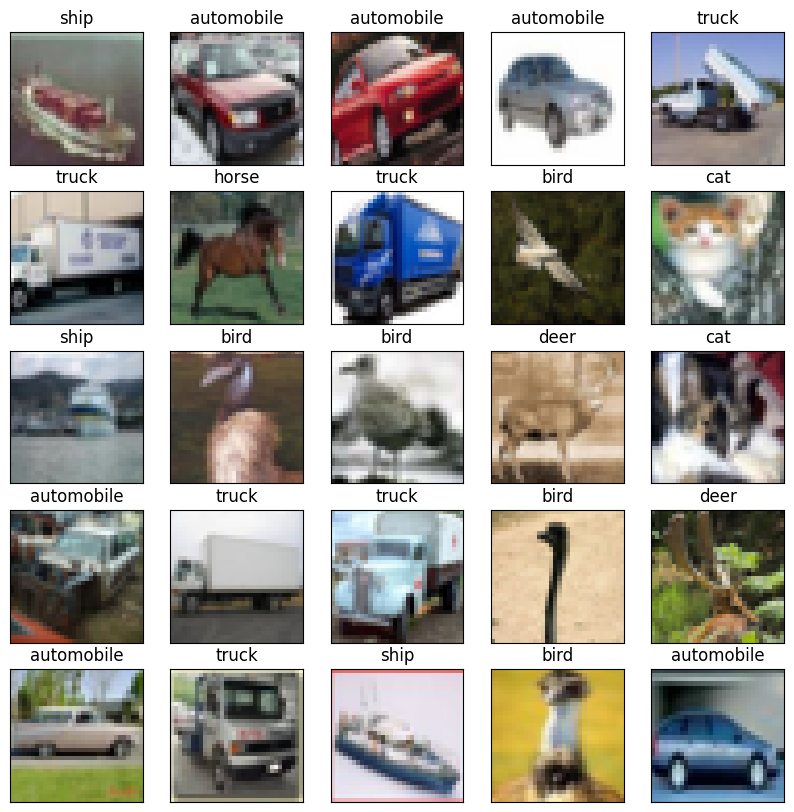

In [21]:
# take the images data from batch data
images = data_1['data']
# take labels of the images 
labels = data_1['labels']
# label names of the images
label_names = meta['label_names']

# reshape and transpose the images
images = images.reshape(len(images),3,32,32).transpose(0,2,3,1)

# dispaly random images
# define row and column of figure
rows, columns = 5, 5
# take random image idex id
imageId = np.random.randint(0, len(images), rows * columns)
# take images for above random image ids
images = images[imageId]
# take labels for these images only
labels = [labels[i] for i in imageId]

# define figure
fig=plt.figure(figsize=(10, 10))
# visualize these random images
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(images[i-1])
    plt.xticks([])
    plt.yticks([])
    plt.title(f"{label_names[labels[i-1]]}")

In [22]:
# class DatasetCIFAR10(Dataset):
#   def __init__(self, path, train=True, transform=None):
#     super().__init__()

#     if train:
#       for i in range(1, 6):
#         fp = path + f'/data_batch_{i}'
#         db = unpickle(fp)
#         data = np.array(db[b'data'])
#         labels = np.array(db[b'labels']).reshape(data.shape[0], 1)
#         dataset = np.concatenate([labels, data], axis = 1)
#         if i==1:
#           self.data = dataset
#         else:
#           self.data = np.concatenate([self.data, dataset])
    
#     else:
#       fp = path + '/test_batch'
#       db = unpickle(fp)
#       data = np.array(db[b'data'])
#       labels = np.array(db[b'labels']).reshape(data.shape[0], 1)
#       self.data = np.concatenate([labels, data], axis = 1)
#     self.transform = transform

#   def __len__(self):
#     return len(self.data)

#   def __getitem__(self, index):
#     # load image as ndarray type (Height * width * channels)
#     # be careful for converting dtype to np.unit8 
#     # image = self.data.iloc[index, 1:].values.astype(np.unit8).reshape((1, 28, 28))
#     # label = self.data.iloc[index, 0]

#     image = self.data[index, 1:]
#     r = image[:1024].reshape(1024, 1)
#     g = image[1024:2048].reshape(1024, 1)
#     b = image[2048:].reshape(1024, 1)
#     image = np.hstack((r, g, b))
#     image = image.reshape(32, 32, 3)
#     label = self.data[index, 0]
#     if self.transform:
#         return self.transform(image), label
#     return image.reshape(3, 32, 32), label

In [23]:
class Cifar10(Dataset):
    def __init__(self, dataset_folder, split='train', transform=None):
        assert split in ['train', 'test'], 'split must be either train or test'
        
        # read paths of batch files and metadata
        if split == 'train':
            batch_files = [file_path for file_path in os.listdir(dataset_folder) if file_path.startswith('data_batch')]
        else:
            batch_files = ['test_batch']

        images = []
        labels = []
        # load images and the labels from the batch files into a list
        for batch in batch_files:
            data = unpickle(os.path.join(dataset_folder, batch))
            batch_images = data['data']
            batch_images = batch_images.reshape(len(batch_images),3,32,32)
            batch_labels = data['labels']

            images.append(batch_images)
            labels += batch_labels

        # stack the images into a single array
        self.images = np.stack(images).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
        self.labels = labels
        self.meta = unpickle(os.path.join(dataset_folder, 'batches.meta'))['label_names']
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]

        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [ ]:
cwd = os.getcwd()  # Get the current working directory (cwd)
os.listdir(cwd)

['.config', 'drive', 'sample_data']

In [25]:
dataset_folder = '/content/drive/MyDrive/Colab/MLDL/LAB1/cifar-10-batches-py'
transform = transforms.ToTensor()
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# instantiate the Dataset class
train_ds = Cifar10(dataset_folder, transform=transform)

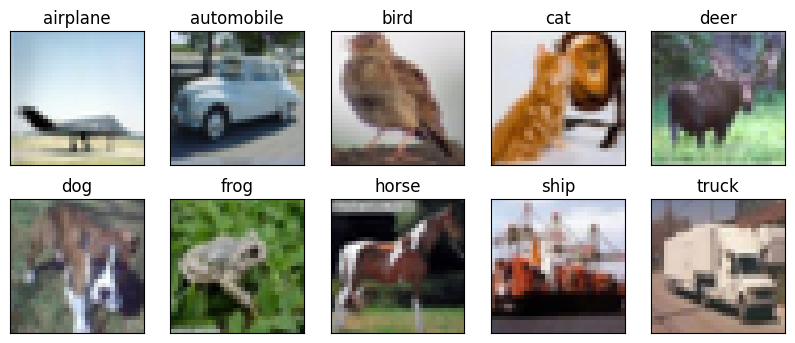

In [26]:
import random
# find one image per class and plot it

labels = np.arange(0, 10)
np_labels = np.array(train_ds.labels)
image_per_class = []
for lab in labels:
    idx = random.choice(np.where(np_labels == lab)[0])
    image_per_class.append(idx)
rows, columns = 2, 5

# define figure
fig=plt.figure(figsize=(10, 4))
# visualize these random images
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(train_ds.images[image_per_class[i-1]])
    plt.xticks([])
    plt.yticks([])
    plt.title(f"{train_ds.meta[labels[i-1]]}")

In [27]:
batch_size = 16
# declare a dataloader for the train dataset
trainloader = DataLoader(train_ds, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# declare a dataset for the test split and its dataloader
test_ds = Cifar10(dataset_folder, split='test', transform=transform)
testloader = DataLoader(test_ds, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# iterate on the dataset using the dataloader (stop after 10 iterations)
for i, (image, label) in enumerate(trainloader):
    if i > 9:
        break
    print(f'batch n.{i}, batch shape: {image.shape}, labels: {label}')

batch n.0, batch shape: torch.Size([16, 3, 32, 32]), labels: tensor([4, 4, 0, 6, 4, 9, 7, 2, 0, 2, 8, 5, 0, 5, 4, 3])
batch n.1, batch shape: torch.Size([16, 3, 32, 32]), labels: tensor([5, 8, 0, 5, 0, 6, 4, 9, 1, 7, 0, 3, 2, 3, 6, 0])
batch n.2, batch shape: torch.Size([16, 3, 32, 32]), labels: tensor([2, 7, 4, 8, 7, 5, 1, 1, 8, 2, 8, 3, 7, 8, 8, 4])
batch n.3, batch shape: torch.Size([16, 3, 32, 32]), labels: tensor([8, 8, 3, 4, 9, 5, 7, 1, 7, 9, 6, 1, 7, 4, 2, 6])
batch n.4, batch shape: torch.Size([16, 3, 32, 32]), labels: tensor([7, 2, 8, 1, 4, 8, 8, 6, 7, 6, 8, 4, 8, 8, 4, 4])
batch n.5, batch shape: torch.Size([16, 3, 32, 32]), labels: tensor([3, 5, 1, 1, 7, 7, 9, 0, 7, 8, 7, 9, 0, 8, 8, 8])
batch n.6, batch shape: torch.Size([16, 3, 32, 32]), labels: tensor([6, 8, 7, 4, 4, 3, 8, 4, 3, 3, 9, 2, 6, 1, 6, 9])
batch n.7, batch shape: torch.Size([16, 3, 32, 32]), labels: tensor([3, 7, 8, 0, 0, 9, 7, 7, 6, 5, 5, 6, 8, 9, 5, 4])
batch n.8, batch shape: torch.Size([16, 3, 32, 32]), lab